In [3]:
### I. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

In [4]:
### II. Load and clean data

df = pd.read_csv("data.csv", delimiter=";")
# Check if there are any columns with the tab character in their name
tab_columns = [col for col in df.columns if '\t' in col]
# print(tab_columns)

# rename them
for col in tab_columns:
    df.rename(columns={col: col.replace('\t', ' ')}, inplace=True)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial' 

# rename some columns
df = df.rename(columns={'Nacionality': 'Nationality', 'Age at enrollment': 'Age',
                       'Daytime/evening attendance ': 'Day/evening attendance'})

#df.head()

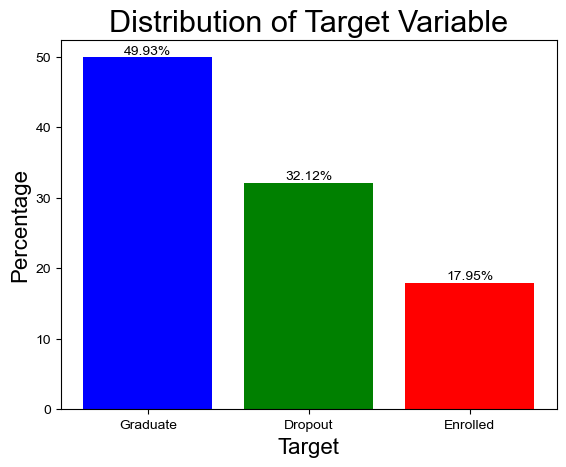

In [5]:
### III. EDA (Exploratory Data Analysis) Categorical Variables 
### Step 1. Descriptive and Visualization
### 1.Distribution of Target Variable

# get value counts of the 'Target'
val_counts = df["Target"].value_counts(normalize=True)*100
bars = plt.bar(val_counts.index, val_counts.values, color = ['blue', 'green', 'red'])
plt.xlabel("Target", fontsize=16)
plt.ylabel("Percentage", fontsize=16)
plt.title("Distribution of Target Variable", fontsize=22)
# adding text labels at the top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, + yval ,f'{yval:.2f}%',
            va='bottom', ha='center')
plt.show()

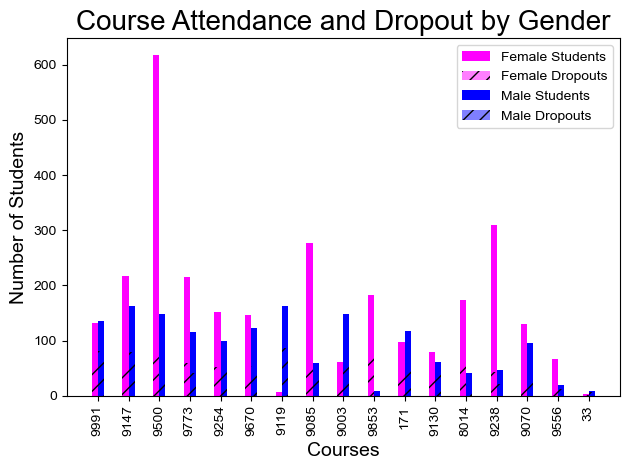

In [6]:
### EDA categorical variables (cont)
### 2. Feature Engineering and 'Course' vs 'Gender' distribution

# let's create a dataframe with the total number of students per course
num_students = df.groupby('Course')['Course'].size().reset_index(name='Num_Students')

# let's count the number of dropouts per course
dropout_count = df[df['Target'] == 'Dropout'].groupby('Course')['Target'].size().reset_index(name='Dropout_Count')

# let's count the total number of females and males per course
gender_count = df.groupby(['Course', 'Gender']).size().unstack(fill_value=0).reset_index()
gender_count.columns = ['Course', 'num_female', 'num_male']

# Now, let's count the number of female and male dropouts per course
dropout_gender_count = df[df['Target'] == 'Dropout'].groupby(['Course', 'Gender']).size().unstack(fill_value=0).reset_index()
dropout_gender_count.columns = ['Course', 'num_dropout_female', 'num_dropout_male']

# Finally, let's merge all these dataframes together
new_df = num_students.merge(dropout_count, on='Course', how='left')
new_df = new_df.merge(gender_count, on='Course', how='left')
new_df = new_df.merge(dropout_gender_count, on='Course', how='left')

# Replace NaNs with 0 for courses with no dropouts and convert float columns to int
new_df = new_df.fillna(0)
cols_to_convert = ['Dropout_Count', 'num_dropout_female', 'num_dropout_male']
new_df[cols_to_convert] = new_df[cols_to_convert].astype(int)

# Sort the DataFrame by 'Dropout_Count' in descending order
new_df = new_df.sort_values(by='Dropout_Count', ascending=False).reset_index(drop=True)

# Sort the DataFrame based on 'Num_students' for better visualization
_newdf = new_df.sort_values('Num_Students', ascending=False)

# Set the positions and width for the bars
positions = np.arange(len(new_df['Course']))
width = 0.2

# Plotting the bars for each gender
plt.bar(positions - width/2, new_df['num_female'], width=width, label='Female Students', color='magenta')
plt.bar(positions - width/2, new_df['num_dropout_female'], width=width, label='Female Dropouts', color='magenta', alpha=0.5, hatch='//')

plt.bar(positions + width/2, new_df['num_male'], width=width, label='Male Students', color='blue')
plt.bar(positions + width/2, new_df['num_dropout_male'], width=width, label='Male Dropouts', color='blue', alpha=0.5, hatch='//')

# Adding labels and title
plt.xlabel('Courses', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.title('Course Attendance and Dropout by Gender', fontsize=20)

# Adding xticks
plt.xticks(positions, new_df['Course'], rotation=90)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [7]:
# List of categorical features encoded as integers
categorical_vars = [
    'Marital status',
    'Application mode',
    'Course',
    'Day/evening attendance',
    'Previous qualification',
    'Nationality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International'
]

# Convert these features to 'category' dtype
for feature in categorical_vars:
    df[feature] = df[feature].astype('category')

### Step 3. Chi-Square Test of Independence
# This dictionary will hold the p-values
p_values = {}

for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['Target'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_values[var] = p

p_values

{'Marital status': 8.054279703889306e-10,
 'Application mode': 1.9646567814647118e-77,
 'Course': 2.3165709040666167e-97,
 'Day/evening attendance': 5.743834299642735e-07,
 'Previous qualification': 7.160305160682533e-30,
 'Nationality': 0.24222552059446276,
 "Mother's qualification": 5.823844464375137e-21,
 "Father's qualification": 3.1750069943476624e-19,
 "Mother's occupation": 1.63085860350197e-31,
 "Father's occupation": 4.51543856251902e-19,
 'Displaced': 2.8763109461402946e-13,
 'Educational special needs': 0.7254049737386095,
 'Debtor': 4.858552123231672e-57,
 'Tuition fees up to date': 1.4716282631420466e-179,
 'Gender': 2.2224795668092454e-51,
 'Scholarship holder': 9.593930375514133e-90,
 'International': 0.5273143969362435}

Top 10 features selected by mutual information:
['Application mode', 'Course', 'Previous qualification', "Mother's qualification", "Mother's occupation", "Father's occupation", 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder']


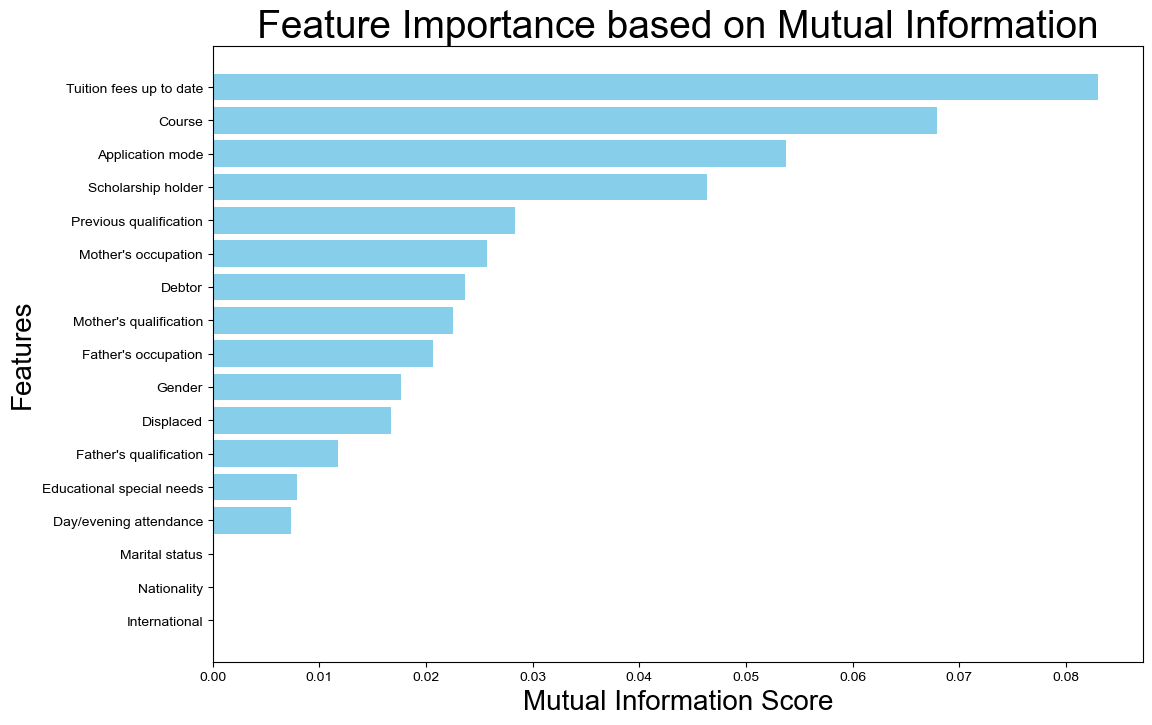

In [8]:
### Step 4. Categorical Feature Selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Prepare the features and target
X_cat = df[categorical_vars] 
y_cat = df['Target'].apply(lambda x: {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}[x])

# Use SelectKBest to select the top k features
k = 10  # or whatever number you prefer
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_cat, y_cat)

# Get the top features
top_features = X_cat.columns[selector.get_support(indices=True)].tolist()
print("Top {} features selected by mutual information:".format(k))
print(top_features)
# Calculate the mutual information scores for each feature
mi_scores = selector.scores_

# Create a pandas DataFrame with the feature names and their corresponding scores
feature_scores = pd.DataFrame({'Feature': categorical_vars, 'Score': mi_scores})

# Sort the DataFrame based on the scores
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Mutual Information Score', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Feature Importance based on Mutual Information', fontsize=28)
plt.gca().invert_yaxis()  # To display the highest score at the top
plt.show()

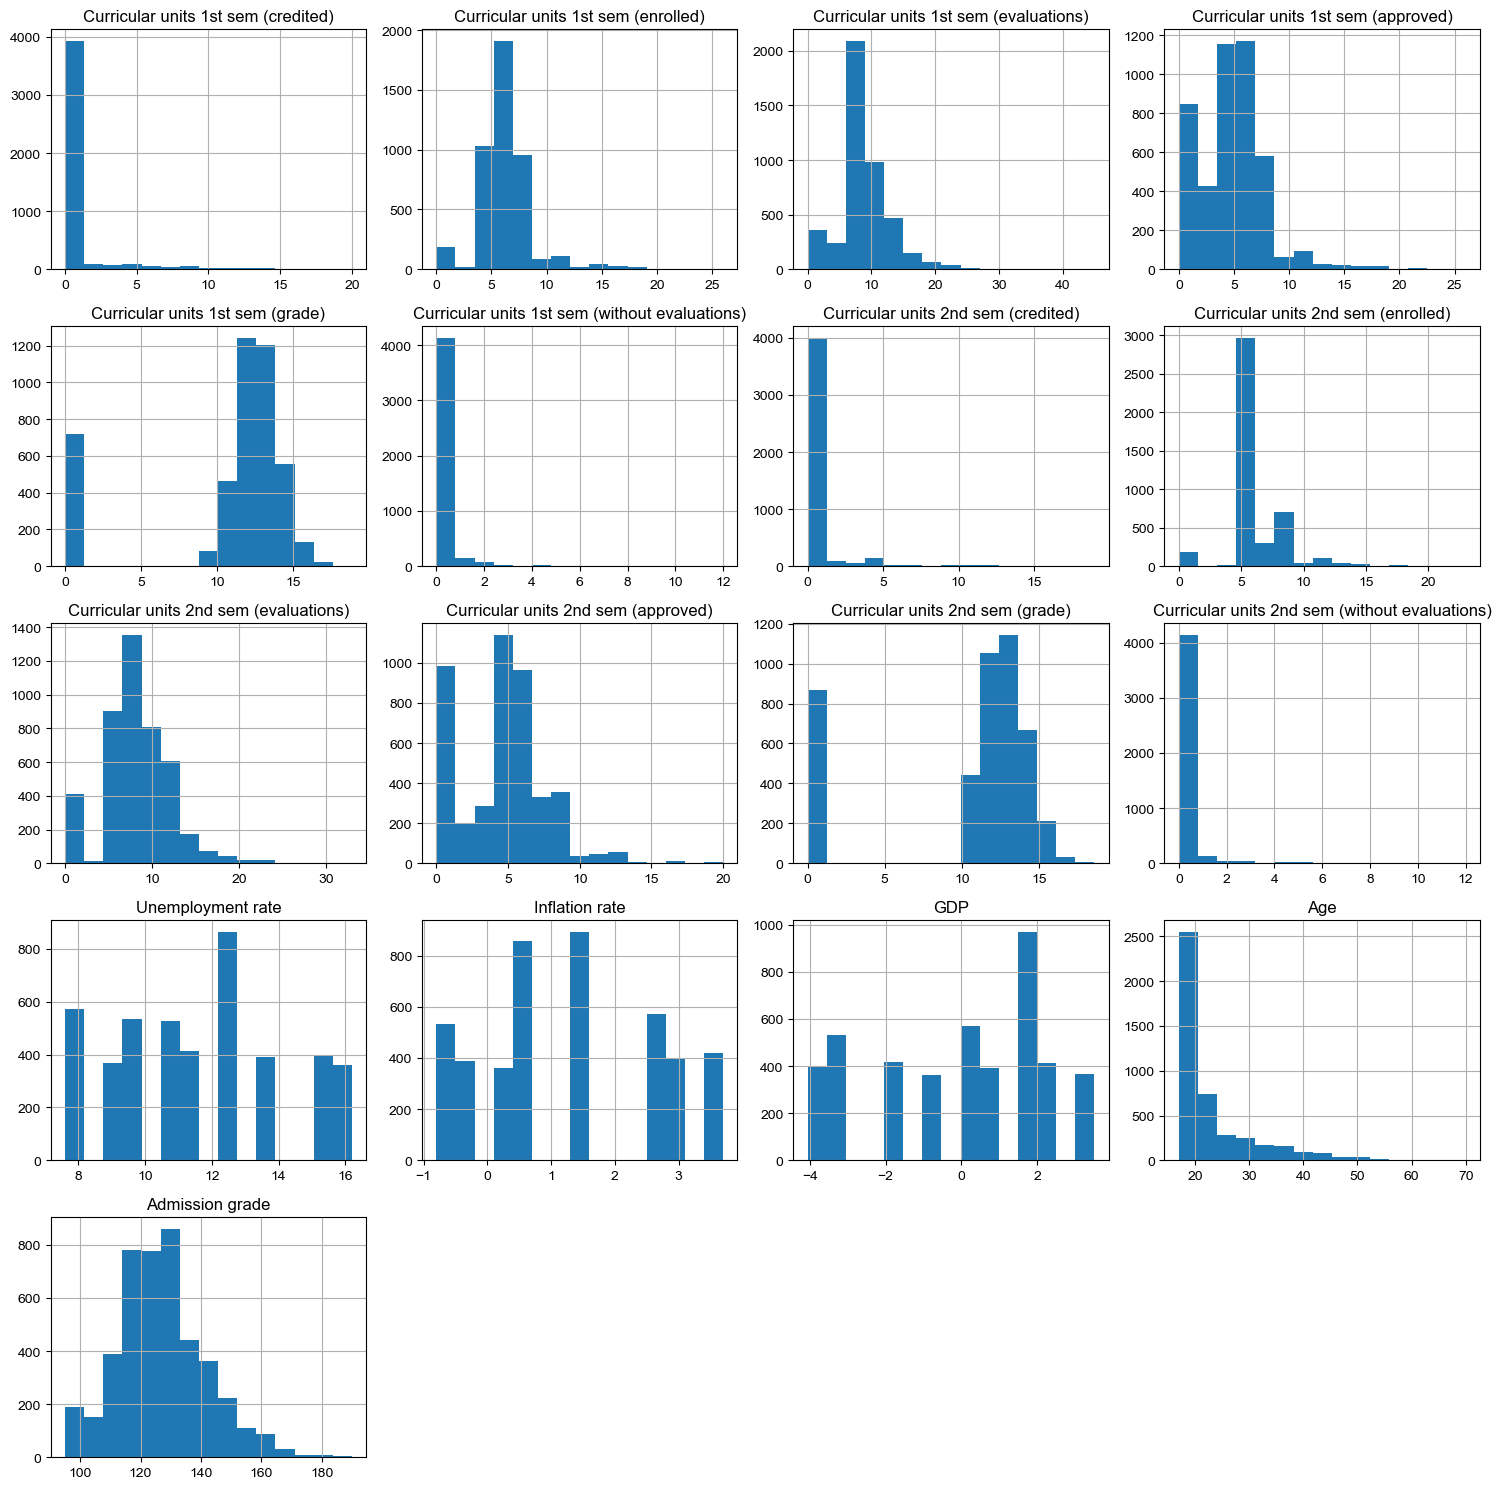

,Variable,Statistic,P-Value
0,Curricular units 1st sem (credited),331.774391,6.470993e-61
1,Curricular units 1st sem (enrolled),2376.571002,0.000000e+00
2,Curricular units 1st sem (evaluations),596.183734,1.474524e-116
3,Curricular units 1st sem (approved),1066.654267,5.905016e-217
4,Curricular units 1st sem (grade),878.784468,9.525150e-177
5,Curricular units 1st sem (without evaluations),385.589719,3.797246e-72
6,Curricular units 2nd sem (credited),314.335728,2.720405e-57
7,Curricular units 2nd sem (enrolled),2483.038146,0.000000e+00
8,Curricular units 2nd sem (evaluations),520.604810,1.478463e-100
9,Curricular units 2nd sem (approved),1152.240048,2.634588e-235


In [9]:
### EDA numerical analysis

### Step 1. Descriptive and Visualization
numerical_vars =['Curricular units 1st sem (credited)',
                 'Curricular units 1st sem (enrolled)',
                 'Curricular units 1st sem (evaluations)',
                 'Curricular units 1st sem (approved)',
                 'Curricular units 1st sem (grade)', 
                 'Curricular units 1st sem (without evaluations)',
                 'Curricular units 2nd sem (credited)',
                 'Curricular units 2nd sem (enrolled)',
                 'Curricular units 2nd sem (evaluations)',
                 'Curricular units 2nd sem (approved)',
                 'Curricular units 2nd sem (grade)',
                 'Curricular units 2nd sem (without evaluations)',
                 'Unemployment rate', 'Inflation rate', 'GDP','Age',
                'Admission grade']
numerical_descriptive_stats = df[numerical_vars].describe()

### Step 2.  Visualizing with histograms
n_rows = 5 
n_cols = 4  
df[numerical_vars].hist(bins=15, figsize=(15, 15), layout=(n_rows, n_cols))
plt.tight_layout()
plt.show()

### Step 3. Run the Kruskal-Wallis H test (data failed the assumption of ANOVA test)

courses = df['Course'].unique()

# List to store the results
kw_results = []

# Run Kruskal-Wallis H test for each numerical variable across courses
for var in numerical_vars:
    # Prepare data for the test
    data_for_test = [df[df['Course'] == course][var] for course in courses]
    
    # Perform the test
    stat, p = kruskal(*data_for_test)
    
    # Store the results
    kw_results.append({'Variable': var, 'Statistic': stat, 'P-Value': p})
    
# Create a DataFrame from the results list
results_df = pd.DataFrame(kw_results)
results_df

Optimal number of features : 16
Selected features: Index(['Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Age', 'Admission grade'],
      dtype='object')
Eliminated features: Index(['Curricular units 1st sem (without evaluations)'], dtype='object')


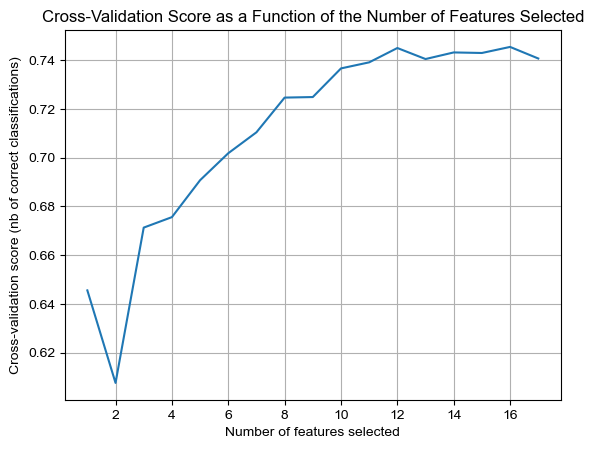

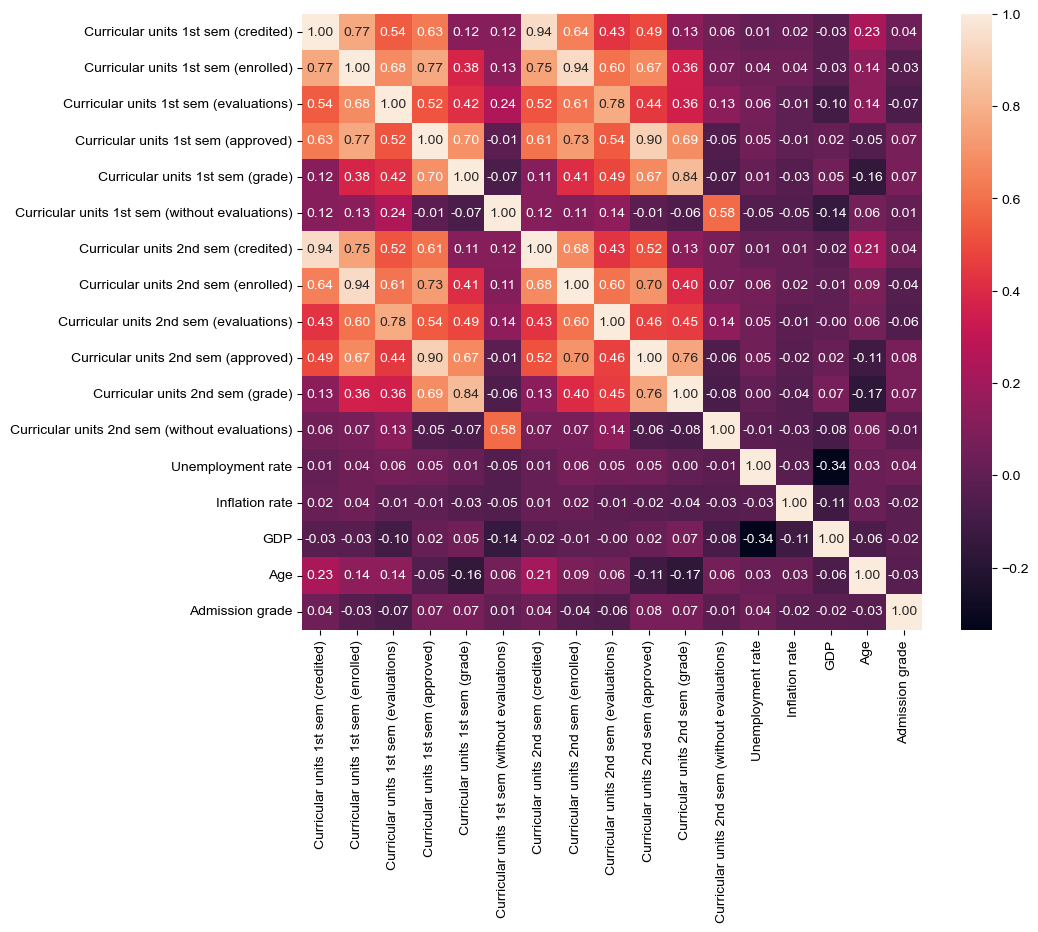

In [10]:
### EDA Numerical Analysis
### Step 4. Feature selection using Recursive Feature Elimination with Cross Validation (RFECV)


X_num = df[numerical_vars]  # independent variables
y_num = df['Target']        # dependent variable

# Create the RFE object and compute a cross-validated score.
clf = RandomForestClassifier()  # can choose any classifier
min_features_to_select = 1      # Minimum number of features to consider
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5),
              scoring='accuracy', min_features_to_select=min_features_to_select)
rfecv.fit(X_num, y_num)

print("Optimal number of features : %d" % rfecv.n_features_)
# After fitting RFECV as shown previously
selected_features = X_num.columns[rfecv.support_]
eliminated_features = X_num.columns[~rfecv.support_]

print("Selected features:", selected_features)
print("Eliminated features:", eliminated_features)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.grid()
plt.title("Cross-Validation Score as a Function of the Number of Features Selected")
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'])
plt.show()

###. Step 5: Correlation Analysis

# Calculate the correlation matrix
corr = df[numerical_vars].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

                                           Feature  Importance
9              Curricular units 2nd sem (approved)    0.190704
10                Curricular units 2nd sem (grade)    0.128405
16                                 Admission grade    0.101823
3              Curricular units 1st sem (approved)    0.100432
4                 Curricular units 1st sem (grade)    0.098098
15                                             Age    0.073772
8           Curricular units 2nd sem (evaluations)    0.057581
2           Curricular units 1st sem (evaluations)    0.053286
14                                             GDP    0.033973
7              Curricular units 2nd sem (enrolled)    0.032582
12                               Unemployment rate    0.032342
13                                  Inflation rate    0.031314
1              Curricular units 1st sem (enrolled)    0.029008
0              Curricular units 1st sem (credited)    0.011012
6              Curricular units 2nd sem (credited)    0

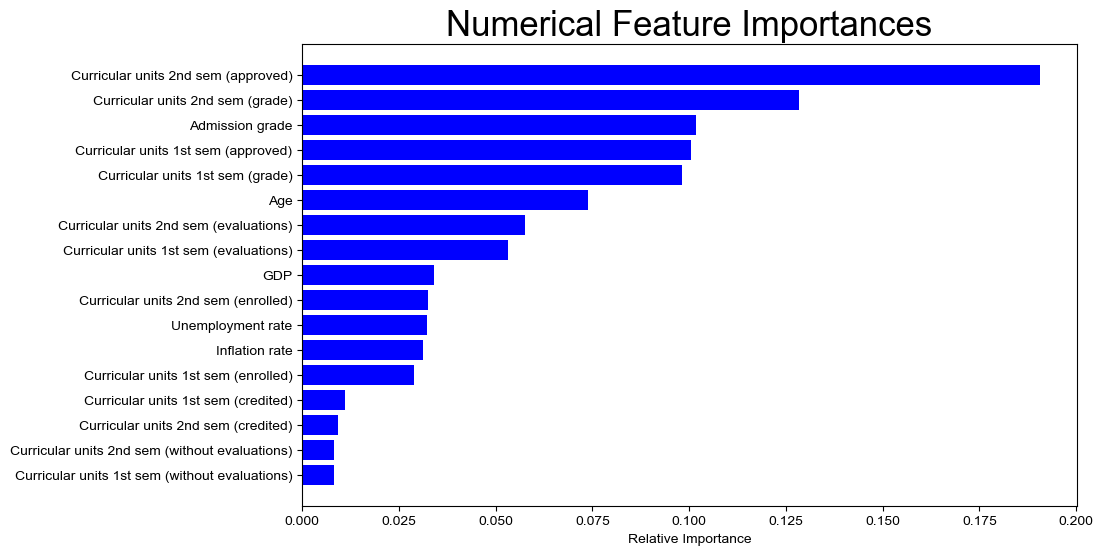

In [11]:
### EDA numerical Analysis (cont)
### Step 6: Model -Based Feature Importance

# Fit the model
model = RandomForestClassifier()
model.fit(X_num, y_num)

# Get feature importances
importances = model.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X_num.columns, 'Importance': importances})

# Sort the DataFrame to show the most important features at the top
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)

# Plotting
plt.figure(figsize=(10, 6))
plt.title('Numerical Feature Importances', fontsize=25)
plt.barh(range(len(importances)), feature_importance_df['Importance'], color='b', align='center')
plt.yticks(range(len(importances)), feature_importance_df['Feature'])
plt.gca().invert_yaxis()  # To display the most important at the top
plt.xlabel('Relative Importance')
plt.show()

In [12]:
### III. Preprocess dataset: 
### Encode categorical features and normalize numeric features

   
# List of categorical features that need to be one-hot encoded.
nominal_cols = ['Application mode', "Course", "Mother's occupation", "Father's occupation"]

# List of ordinal features that need to be label encoded.
ordinal_cols = ["Previous qualification", "Father's qualification"]

# List of binary features that can be directly cast to integers.
binary_cols = ['Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder']

# Step 1: One-Hot Encoding for nominal columns
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(df[nominal_cols]).toarray()
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out())

# Step 2: Label Encoding for ordinal columns
label_encoder = LabelEncoder()
for col in ordinal_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Step 3: Directly cast binary columns to integers
for col in binary_cols:
    df[col] = df[col].astype(int)

# Step 4: Scaling numerical variables

scaler = StandardScaler()
df[numerical_vars] = scaler.fit_transform(df[numerical_vars])

# Step 5: Combine the dataframes
# Drop the original nominal columns from df as they have been one-hot encoded
df = df.drop(columns=nominal_cols)

# Combine one-hot encoded df with the main df
# Ensure that the indices of both dataframes match before concatenation
combined_df = pd.concat([df.reset_index(drop=True), one_hot_encoded_df.reset_index(drop=True)], axis=1)


#### Novelty Approach
* If the article already uses methods like decision trees, random forest, and XGBoost, the novelty of applying clustering would not lie in the algorithms themselves but in how we integrate clustering with these methods and the insights we derive from them. Here's how clustering can add a novel dimension to the analysis:
    1. Segmentation Before Prediction:
    2. Inter-cluster Comparison
    3. Feature Engineering:
    4. Cluster Characterization
    5. Tailored Interventions


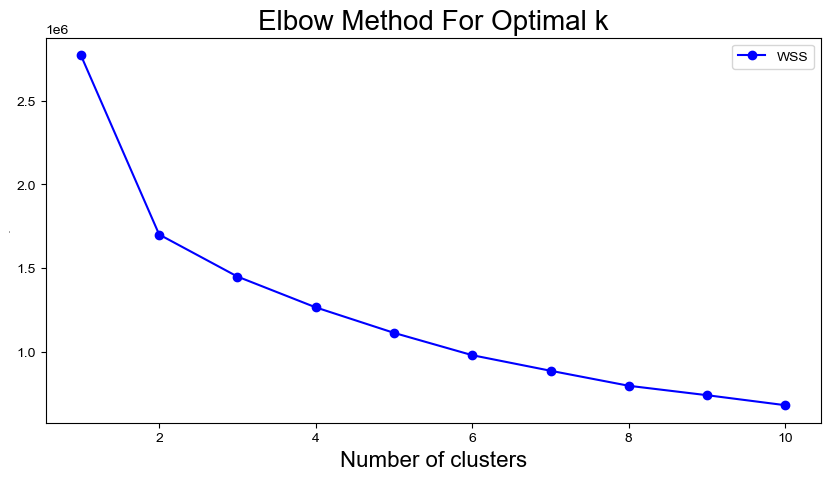

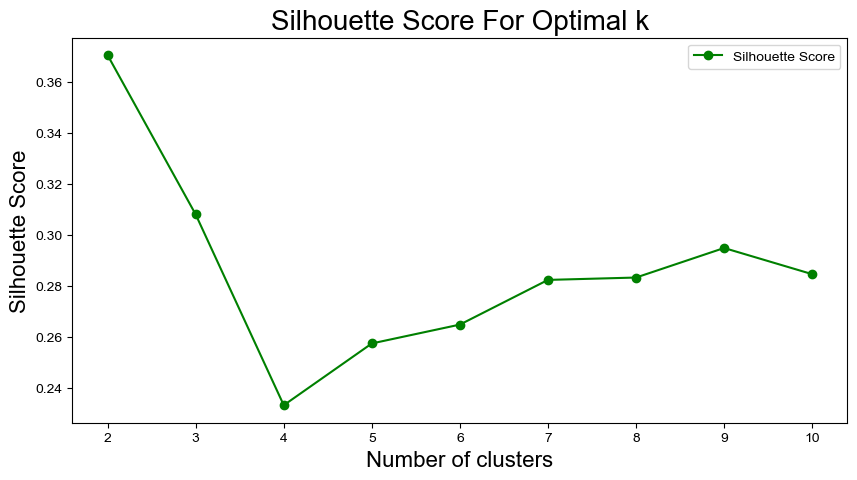

In [13]:
### IV. Segmented data using K-Means and Silhouette Scores
### 1. Finding the optimal number of cluster

# Function to calculate WSS (Within-Cluster-Sum of Squared Errors)
def calculate_wss(data, max_k):
    wss = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(data)
        wss.append(kmeans.inertia_)
    return wss

# Function to calculate Silhouette Scores
def calculate_silhouette(data, max_k):
    silhouette_scores = []
    for k in range(2, max_k+1):  # silhouette score can't be computed for k=1
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores

if 'Target' in combined_df:
    features_df = combined_df.drop('Target', axis=1)
else:
    features_df = combined_df.copy()
# Using the elbow method to find the optimal number of clusters
max_k = 10
wss = calculate_wss(features_df, max_k)
k_values = range(1, max_k+1)

# Plotting the WSS scores
plt.figure(figsize=(10,5))
plt.plot(k_values, wss, 'bo-', label='WSS')
plt.title('Elbow Method For Optimal k', fontsize=20)
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('WSS', fontsize=1)
plt.legend()
plt.show()

# Calculating Silhouette Scores
silhouette_scores = calculate_silhouette(features_df, max_k)

# Plotting the silhouette scores
plt.figure(figsize=(10,5))
plt.plot(range(2, max_k+1), silhouette_scores, 'go-', label='Silhouette Score')
plt.title('Silhouette Score For Optimal k', fontsize=20)
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Silhouette Score',fontsize=16)
plt.legend()
plt.show()


In [23]:
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency

# Step 1: Cluster Assignment
kmeans = KMeans(n_clusters=2,n_init=10, random_state=42)
features_df['Cluster'] = kmeans.fit_predict(features_df)

# Step 2: Combine Cluster Labels with Target
# Make sure to align the indices correctly if they were reset during preprocessing
original_target_df = df[['Target']].reset_index(drop=True)
combined_cluster_target_df = pd.concat([features_df['Cluster'], original_target_df], axis=1)

# Step 3: Crosstab Analysis
cluster_crosstab = pd.crosstab(combined_cluster_target_df['Cluster'], combined_cluster_target_df['Target'])

# Calculate the dropout rate per cluster
dropout_rates = cluster_crosstab['Dropout'] / cluster_crosstab.sum(axis=1)
print(dropout_rates)

# Step 4: Chi-Square Test
chi2_stat, p_val, dof, ex = chi2_contingency(cluster_crosstab)

print('Chi-Square Statistic:', chi2_stat)
print('P-value:', p_val)


Cluster
0    0.299037
1    0.344860
dtype: float64
Chi-Square Statistic: 14.819991112985212
P-value: 0.0006051733836214834


* The crosstab shows the distribution of student outcomes (Dropout, Enrolled, Graduate) within each cluster.
* Cluster 0 consists of 683 Dropouts, 448 Enrolled, and 1153 Graduates.
* Cluster 1 consists of 738 Dropouts, 346 Enrolled, and 1056 Graduates.
* The dropout rate for Cluster 0 is approximately 29.9%, and for Cluster 1, it is approximately 34.5%.
* The chi-square test of independence gives a statistic of 14.819991112985212 and a very small p-value of 0.0006051733836214834. Since the p-value is less than the typical alpha level of 0.05,we can reject the null hypothesis and conclude that there is a statistically significant association between cluster assignment and student outcomes.

* From these results, it is evident that:

    * There is a higher rate of dropouts in Cluster 1 compared to Cluster 0.
    * The difference in dropout rates between the two clusters is statistically significant.

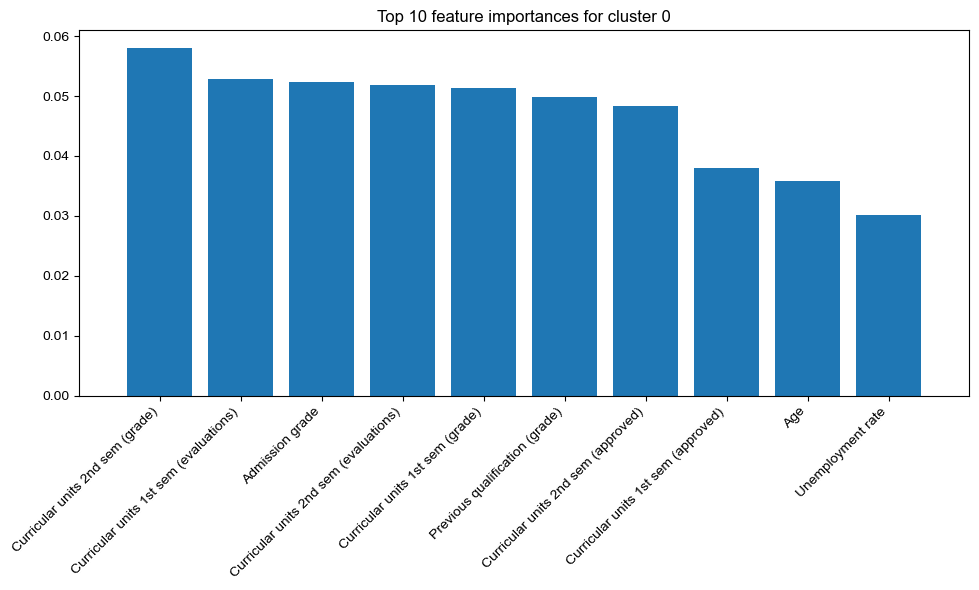

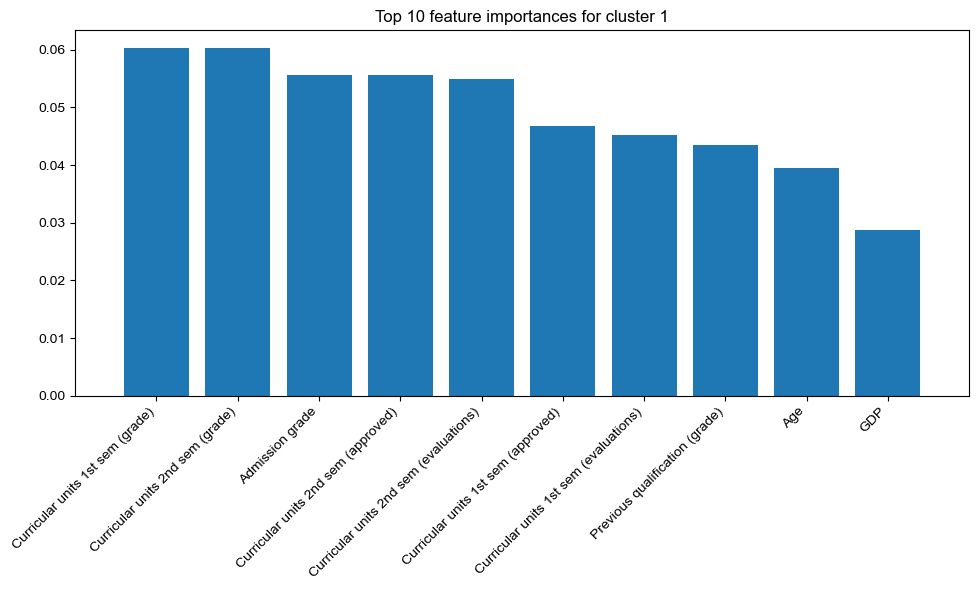

In [24]:
# Define the function to train Random Forest and extract feature importances
def get_feature_importances(X, y):
    # Initialize the Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # Fit the model
    rf.fit(X, y)
    # Return the feature importances
    return rf.feature_importances_

# Dictionary to hold feature importances for each cluster
cluster_feature_importances = {}

# Loop over each cluster
for cluster in features_df['Cluster'].unique():
    # Subset the data to the current cluster
    cluster_data = features_df[features_df['Cluster'] == cluster]
    cluster_target = combined_df.loc[cluster_data.index, 'Target']
    
    # Prepare the inputs for feature importance function
    X_cluster = cluster_data.drop(['Cluster', 'Target'], axis=1, errors='ignore')
    y_cluster = cluster_target.apply(lambda x: 1 if x == 'Enrolled' else 0)
    
    # Get the feature importances
    importances = get_feature_importances(X_cluster, y_cluster)
    
    # Store the importances in the dictionary
    cluster_feature_importances[cluster] = importances

# Now, cluster_feature_importances contains the importances for each cluster
# Let's visualize the top N feature importances for each cluster
N = 10
feature_names = X_cluster.columns
for cluster, importances in cluster_feature_importances.items():
    # Sort the feature importances
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:N]

    
    # Plot the feature importances of the cluster
    plt.figure(figsize=(10, 6))
    plt.title(f"Top {N} feature importances for cluster {cluster}")
    plt.bar(range(N), importances[top_indices], align='center')
    
    # Add feature names as x-axis labels
    plt.xticks(range(N), feature_names[top_indices], rotation=45, ha='right')
    plt.xlim([-1, N])
    plt.tight_layout()  # Adjust the layout to fit the labels
    plt.show()


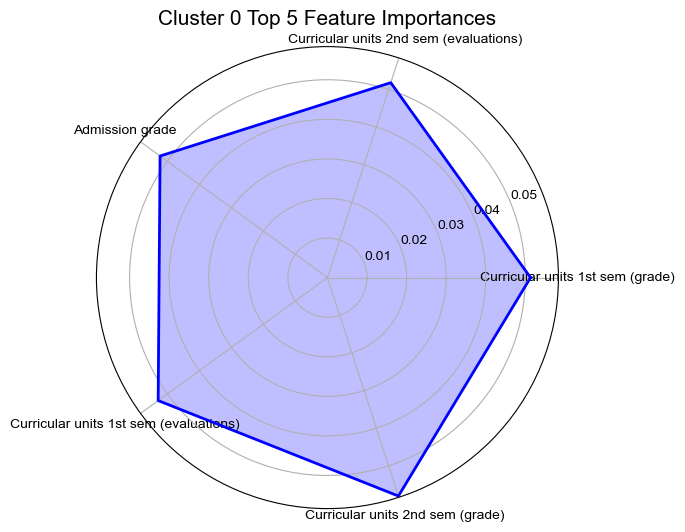

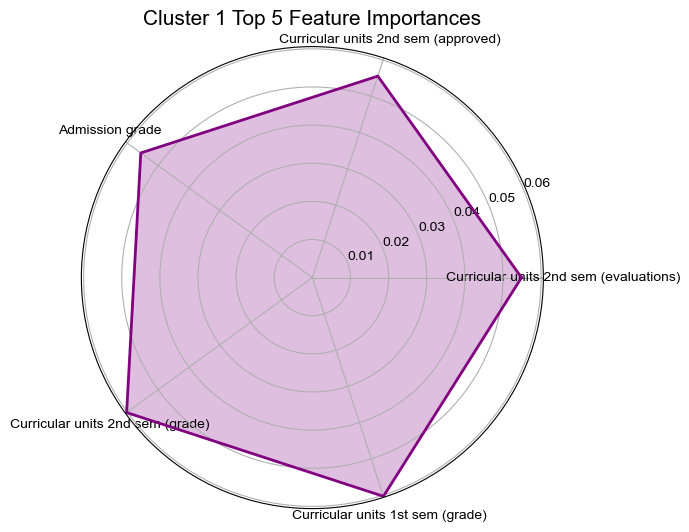

In [25]:
from math import pi
color_map = {
    0: 'blue',
    1: 'purple'
}

# Function to create a radar chart for a given cluster's feature importances
def plot_radar_chart(cluster, feature_importances, feature_names, N, color_map):
    # Choose the top N features for the cluster
    sorted_idx = np.argsort(feature_importances)[-N:]  # Get the indices of the top N features
    
    # Create a list of evenly spaced angles
    angles = np.linspace(0, 2 * np.pi, len(sorted_idx), endpoint=False).tolist()  # One angle for each feature
    angles += angles[:1]  # Repeat the first angle to close the circle
    
    # Get the feature importances for the top N features and repeat the first value to close the circle
    values = feature_importances[sorted_idx].tolist()
    values += values[:1]
    
    # Set up the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Draw the outline of our data.
    ax.plot(angles, values, color=color_map[cluster], linewidth=2)
    # Fill in the outline with color.
    ax.fill(angles, values, color=color_map[cluster], alpha=0.25)
    
    # Fix the number of ticks and labels on the radar chart
    ax.set_xticks(angles[:-1])  # Set ticks at each angle
    ax.set_xticklabels([feature_names[i] for i in sorted_idx])  # Set feature names as labels, omitting the repeated first label
    
    # Set the title for the radar chart
    ax.set_title(f'Cluster {cluster} Top {N} Feature Importances', size=15)
    
    # Show the plot
    plt.show()

# Determine the number of top features to display on the radar chart
N = 5

# Plot a radar chart for each cluster
for cluster, importances in cluster_feature_importances.items():
    plot_radar_chart(cluster, importances, feature_names, N, color_map)



1. For Cluster 0, the features from most to least important are:

    * Curricular units 2nd sem (evaluations)
    * Curricular units 1st sem (grade)
    * Curricular units 2nd sem (grade)
    * Admission grade
    * Curricular units 1st sem (evaluations)
    
2. For Cluster 1, the features from most to least important are:

    *  Curricular units 2nd sem (approved)
    * Curricular units 2nd sem (evaluations)
    * Curricular units 2nd sem (grade)
    * Curricular units 1st sem (grade)
    * Admission grade

1. Comparing these with the XGB and RF feature importances:

    * "Curricular units 2nd sem (approved)" is the top feature for both XGB and RF and is also a top feature for Cluster 1, but not for Cluster 0.
    * "Curricular units 2nd sem (evaluations)" is a common top feature across all models and both clusters.
    * "Curricular units 1st sem (grade)" and "Curricular units 2nd sem (grade)" appear in both clusters but are not top features in the traditional XGB and RF models.
    * "Admission grade" appears as a lower importance feature in Cluster 0 and 1, whereas in RF it has a higher importance but is not present in the top features for XGB.

2. The differences between the traditional models (XGB and RF) and the clustering approach suggest that the feature importance may vary significantly depending on the modeling technique. While traditional models might indicate the overall importance of features across the entire dataset, the cluster-specific importances highlight that different subsets of the data (i.e., each cluster) may be influenced more by different features.

In [19]:
### Create function train_evaluate_cluster() to train and evaluate models'performance for each cluster
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
def train_evaluate_cluster(cluster_data, cluster_target, n_splits=5):
    """
    Train and evaluate a Random Forest model for a given cluster with SMOTE and cross-validation.
    Args:
    - cluster_data: The feature data for the cluster
    - cluster_target: The target variable for the cluster
    - n_splits: Number of folds for cross-validation

    Returns:
    - A dictionary containing the evaluation metrics including train and test errors
    """
    # Define numeric and categorical features
    numeric_features = cluster_data.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = cluster_data.select_dtypes(include=['object', 'category']).columns

    # Define the cross-validation strategy
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define the preprocessing for numeric features: imputation + scaling
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Define the preprocessing for categorical features: imputation + one-hot encoding
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Create the ColumnTransformer to apply the transformations to the correct features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Define the SMOTE + RandomForest pipeline
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(
            n_estimators=500, 
            max_depth=20, 
            min_samples_split=200,
            min_samples_leaf=100,
            max_features='sqrt',
            random_state=42))
    ])
    
    # Store the metrics
    metrics = {
        'train_accuracy': [],
        'test_accuracy': [],
        'train_error': [],
        'test_error': [],
        'confusion_matrix': [],
        'classification_report': []
    }
    
    # Perform cross-validation
    for train_idx, test_idx in cv.split(cluster_data, cluster_target):
        X_train, X_test = cluster_data.iloc[train_idx], cluster_data.iloc[test_idx]
        y_train, y_test = cluster_target.iloc[train_idx], cluster_target.iloc[test_idx]
        
        # Fit the pipeline
        pipeline.fit(X_train, y_train)
        
        # Make predictions on the training data
        y_train_pred = pipeline.predict(X_train)
        
        # Make predictions on the test data
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)
        metrics['train_accuracy'].append(train_accuracy)
        metrics['test_accuracy'].append(test_accuracy)
        metrics['train_error'].append(1 - train_accuracy)
        metrics['test_error'].append(1 - test_accuracy)
        metrics['confusion_matrix'].append(confusion_matrix(y_test, y_pred))
        metrics['classification_report'].append(classification_report(y_test, y_pred))
    
    # Aggregate the metrics
    avg_train_accuracy = sum(metrics['train_accuracy']) / n_splits
    avg_test_accuracy = sum(metrics['test_accuracy']) / n_splits
    avg_train_error = sum(metrics['train_error']) / n_splits
    avg_test_error = sum(metrics['test_error']) / n_splits
    
    
    # Print the evaluation metrics for the cluster
    print(f"Cluster Evaluation Metrics:")
    print(f"Average Train Accuracy: {avg_train_accuracy}")
    print(f"Average Test Accuracy: {avg_test_accuracy}")
    print(f"Average Train Error: {avg_train_error}")
    print(f"Average Test Error: {avg_test_error}")
    
    return metrics


In [20]:
# Ensure that 'Cluster' assignments are present in features_df after clustering
features_df['Cluster'] = kmeans.fit_predict(features_df)

# Dictionary to hold the evaluation metrics for each cluster
cluster_evaluation_metrics = {}

# Loop over each cluster number assigned by K-Means
for cluster_label in features_df['Cluster'].unique():
    # Select rows for the cluster from features_df
    cluster_indices = features_df[features_df['Cluster'] == cluster_label].index
    
    # Use these indices to select matching rows from original df to get the 'Target'
    cluster_target = df.loc[cluster_indices, 'Target']
    
    # Use the same indices to select matching rows from combined_df to get the features
    cluster_features = combined_df.loc[cluster_indices]
    
    # Apply the train and evaluate function to the cluster data
    metrics = train_evaluate_cluster(cluster_features, cluster_target)
    
    # Store the metrics in the dictionary using the cluster label as the key
    cluster_evaluation_metrics[cluster_label] = metrics


Cluster Evaluation Metrics:
Average Train Accuracy: 0.9761381370375561
Average Test Accuracy: 0.9746103497255174
Average Train Error: 0.02386186296244397
Average Test Error: 0.0253896502744827
Cluster Evaluation Metrics:
Average Train Accuracy: 0.9792056074766355
Average Test Accuracy: 0.9752336448598131
Average Train Error: 0.020794392523364458
Average Test Error: 0.024766355140186925


In [374]:
for cluster_label, metrics in cluster_evaluation_metrics.items():
    print(f"Metrics for Cluster {cluster_label}:")
    
    # Confusion Matrices for each fold
    print("Confusion Matrices:")
    for cm in metrics['confusion_matrix']:
        print(cm)
    
    # Classification Reports for each fold
    print("\nClassification Reports:")
    for cr in metrics['classification_report']:
        print(cr)


    print("\n")  # Newline for better readability between clusters


Metrics for Cluster 0:
Confusion Matrices:
[[132   0   5]
 [  1  88   0]
 [  9   0 222]]
[[133   0   4]
 [  1  89   0]
 [  7   0 223]]
[[136   0   1]
 [  2  87   1]
 [  9   0 221]]
[[131   0   5]
 [  0  90   0]
 [  6   0 225]]
[[132   0   4]
 [  0  89   0]
 [  3   0 228]]

Classification Reports:
              precision    recall  f1-score   support

     Dropout       0.93      0.96      0.95       137
    Enrolled       1.00      0.99      0.99        89
    Graduate       0.98      0.96      0.97       231

    accuracy                           0.97       457
   macro avg       0.97      0.97      0.97       457
weighted avg       0.97      0.97      0.97       457

              precision    recall  f1-score   support

     Dropout       0.94      0.97      0.96       137
    Enrolled       1.00      0.99      0.99        90
    Graduate       0.98      0.97      0.98       230

    accuracy                           0.97       457
   macro avg       0.98      0.98      0.98      

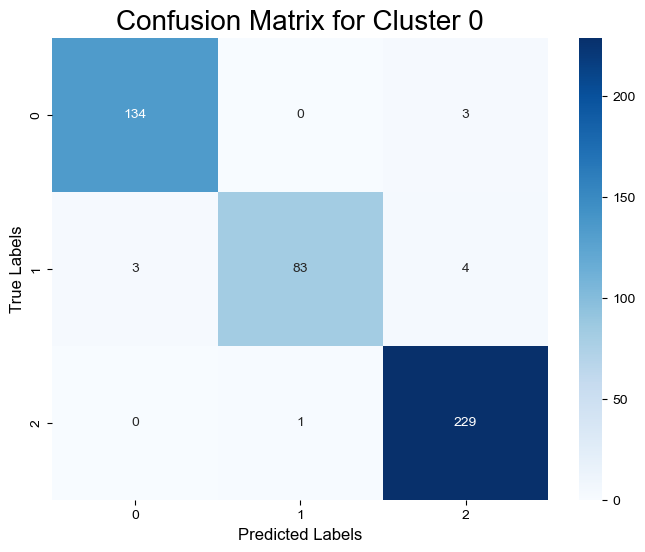

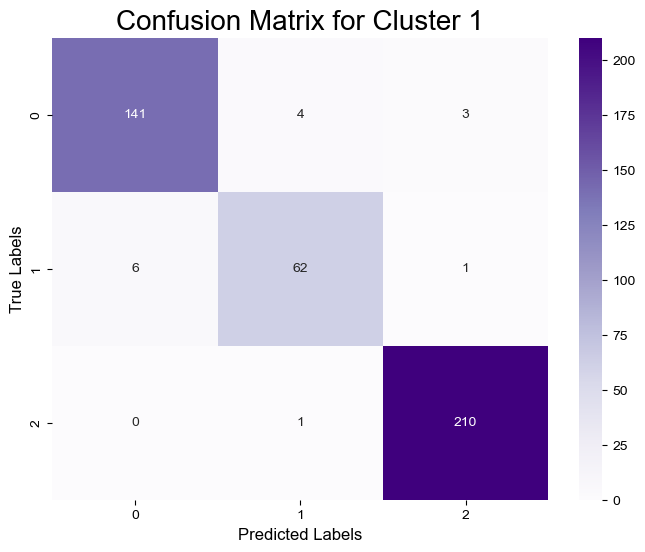

In [375]:
# Confusion matrix for Cluster 0 (fold 3)
confusion_matrix_cluster0 = np.array([[134, 0, 3], [3, 83, 4], [0, 1, 229]])

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_cluster0, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Cluster 0', fontsize=20)
plt.xlabel('Predicted Labels',fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# Confusion matrix for Cluster 1 (fold 1)
confusion_matrix_cluster1 = np.array([[141, 4, 3], [6, 62, 1], [0, 1, 210]])

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_cluster1, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix for Cluster 1', fontsize=20)
plt.xlabel('Predicted Labels',fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

In [376]:
### Aggregated confusion matrices and classification report (5 folds)

for cluster_label, metrics in cluster_evaluation_metrics.items():
    print(f"Metrics for Cluster {cluster_label}:")

    # Sum the confusion matrices from each fold to get one confusion matrix for the cluster
    total_confusion_matrix = np.sum(metrics['confusion_matrix'], axis=0)
    print("Total Confusion Matrix:")
    print(total_confusion_matrix)

    # Calculate overall accuracy for multi-class classification
    accuracy = np.trace(total_confusion_matrix) / np.sum(total_confusion_matrix)

    # Calculate precision, recall, and F1-score for each class
    precision = np.diag(total_confusion_matrix) / np.sum(total_confusion_matrix, axis=0)
    recall = np.diag(total_confusion_matrix) / np.sum(total_confusion_matrix, axis=1)
    f1_scores = 2 * precision * recall / (precision + recall)

    # Calculate weighted average for precision, recall, and F1-score
    support = np.sum(total_confusion_matrix, axis=1)
    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1_score = np.average(f1_scores, weights=support)

    # Print the aggregated classification report
    print("\nAggregated Classification Report:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision (weighted): {weighted_precision:.2f}")
    print(f"Recall (weighted): {weighted_recall:.2f}")
    print(f"F1-score (weighted): {weighted_f1_score:.2f}\n")


Metrics for Cluster 0:
Total Confusion Matrix:
[[ 664    0   19]
 [   4  443    1]
 [  34    0 1119]]

Aggregated Classification Report:
Accuracy: 0.97
Precision (weighted): 0.97
Recall (weighted): 0.97
F1-score (weighted): 0.97

Metrics for Cluster 1:
Total Confusion Matrix:
[[ 726    0   12]
 [  13  331    2]
 [  26    0 1030]]

Aggregated Classification Report:
Accuracy: 0.98
Precision (weighted): 0.98
Recall (weighted): 0.98
F1-score (weighted): 0.98



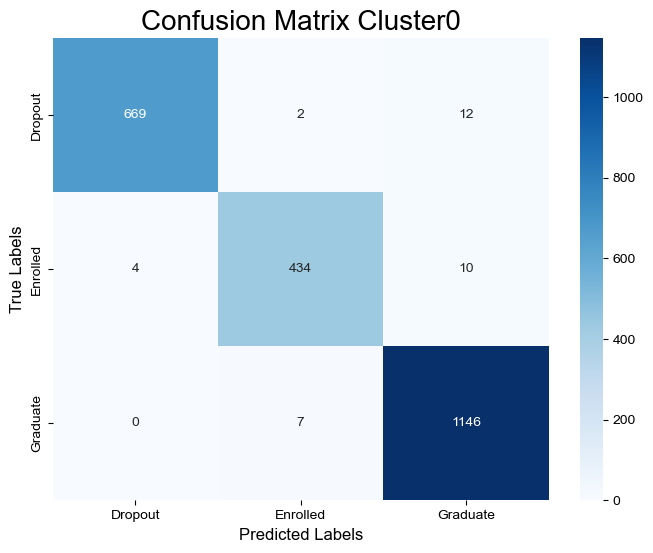

<Figure size 800x600 with 0 Axes>

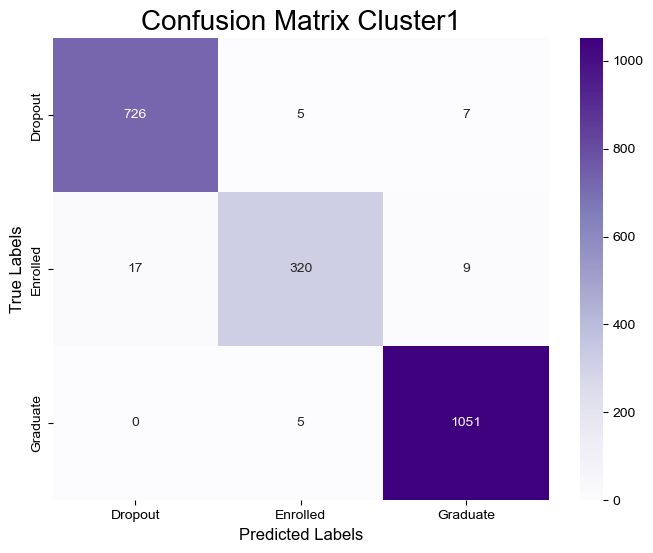

In [42]:
###
# Aggregated Confusion matrix for Cluster 0
cm_cluster0 = np.array([[669, 2, 12], [4, 434, 10], [0, 7, 1146]])

# Plotting the heatmap
class_labels = ['Dropout', 'Enrolled', 'Graduate']
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cluster0, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Cluster0', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# Aggregated Confusion matrix for Cluster 1
cm_cluster1 = np.array([[726, 5, 7], [17, 320, 9], [0, 5, 1051]])
# Plotting the heatmap
plt.figure(figsize=(8, 6))
class_labels = ['Dropout', 'Enrolled', 'Graduate']
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cluster1, annot=True, fmt='d', cmap='Purples',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Cluster1', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

##### Summary:
1. It's evident that building separate Random Forest models for each cluster can be a valuable approach. By segmenting the data into clusters, we're hypothesizing that there are distinct patterns or behaviors within each group that a global model might not capture effectively..
2. Why build separate models for each cluster?
    1. Tailored modeling: Each cluster prepresent a group with differetnt characteristics. A model tailored to each group can more accurately capture these unique patterns
    2. Improved performance: Global models may average out or mis nuances specific to each cluster, leading to suboptimal performance
    3. Insightful feature importance: Different clusters may prioritize different features. Separate models can reveal these differences.
    4. Custom interventions: Understanding each cluster's behavior allows for more targeted interventions, policies, or strategies
3. How to build randomforest models for each cluster?
    1. Split the data: After clustering, divive the dataset based on the cluster assignment
    2. Preprocess. Ensure that each subset is properly preprocessed. Handle imbalanced classes within each cluster as needed
    3. Hyperparameter Turning: For each subset, perform hyperparameter tuning to find the best parameters for the RandomForest model. This can be done through gridsearch, random search, or other optimization tecniques
    4. Train the model: Trai the RF model on each subset using tuned parameters
    5. Validate: Perform cross-validation within each cluster to estimate the model's performance reliability
    6. Feature Importance: Extract and analyze feature importance form each model to understan what drives predictions in each cluster
    7. Report and compare: Compare model performance and feature importance across clusters to draws insights

    

##### Current Approach:

In [26]:
# Splitting the data into features and target
X = df.drop('Target', axis=1)
y = df['Target']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
def decision_tree_model(X_train, y_train, X_test, y_test):
    # Convert y_train and y_test to NumPy arrays 
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, -1].values 
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, -1].values

    # Apply SMOTE
    smote = SMOTE()
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Define model and parameters
    dtree = DecisionTreeClassifier()
    parameters = {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

    # Hyperparameter tuning
    grid_search = GridSearchCV(dtree, parameters, cv=5, scoring='accuracy')
    grid_search.fit(X_train_smote, y_train_smote)
    best_dt = grid_search.best_estimator_

    # Cross-validation and evaluation
    cv_scores = cross_val_score(best_dt, X_train_smote, y_train_smote, cv=5)
    best_dt.fit(X_train_smote, y_train_smote)
    y_pred = best_dt.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return best_dt,cv_scores, cm, report

In [28]:
best_dt, dt_cv_scores, dt_cm, dt_report = decision_tree_model(X_train, y_train, X_test, y_test)
print('Decision Tree CV scores:', dt_cv_scores,'\n')
print('Decisiion Tree Confusion matrix:', dt_cm, '\n')
print('Decision Tree Classification Report:', dt_report)

Decision Tree CV scores: [0.64744186 0.67348837 0.71906977 0.79143389 0.79143389] 

Decisiion Tree Confusion matrix: [[227  46  43]
 [ 43  65  43]
 [ 29  48 341]] 

Decision Tree Classification Report:               precision    recall  f1-score   support

     Dropout       0.76      0.72      0.74       316
    Enrolled       0.41      0.43      0.42       151
    Graduate       0.80      0.82      0.81       418

    accuracy                           0.72       885
   macro avg       0.66      0.65      0.65       885
weighted avg       0.72      0.72      0.72       885



In [29]:
best_dt

DecisionTreeClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10)

In [30]:
def rf_model(X_train, y_train, X_test, y_test):
    # Convert y_train and y_test to NumPy arrays 
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, -1].values  
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, -1].values
        
    # Create an imputer object with a median filling strategy
    imputer = SimpleImputer(strategy='median')

    # Apply the imputer to your data
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Apply SMOTE
    smote = SMOTE()
    X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

    # Define model and parameters
    rf = RandomForestClassifier()
    # define the parameters
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10, 20]
    }

    # Hyperparameter tuning
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', error_score='raise')
    grid_search.fit(X_train_smote, y_train_smote)
    best_rf = grid_search.best_estimator_

    # Cross-validation and evaluation
    cv_scores = cross_val_score(best_rf, X_train_smote, y_train_smote, cv=5)
    best_rf.fit(X_train_smote, y_train_smote)
    y_pred = best_rf.predict(X_test_imputed)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return best_rf, cv_scores, cm, report

In [31]:
best_rf, rf_cv_scores, rf_cm, rf_report = rf_model(X_train, y_train, X_test, y_test)
print('Random Forest CV scores:', rf_cv_scores,'\n')
print('Random Forest Confusion matrix:', rf_cm, '\n')
print('Random Forest Classification Report:', rf_report, '\n')

Random Forest CV scores: [0.73767442 0.76930233 0.85302326 0.89013035 0.87337058] 

Random Forest Confusion matrix: [[231  42  43]
 [ 26  67  58]
 [  8  33 377]] 

Random Forest Classification Report:               precision    recall  f1-score   support

     Dropout       0.87      0.73      0.80       316
    Enrolled       0.47      0.44      0.46       151
    Graduate       0.79      0.90      0.84       418

    accuracy                           0.76       885
   macro avg       0.71      0.69      0.70       885
weighted avg       0.76      0.76      0.76       885
 



In [32]:
best_rf

RandomForestClassifier(n_estimators=200)

In [33]:
def nn_model(X_train, y_train, X_test, y_test):
    # Convert y_train and y_test to NumPy arrays
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, -1].values 
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, -1].values

    # Create an imputer object with a median filling strategy
    imputer = SimpleImputer(strategy='median')

    # Apply the imputer to your data
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    # Apply SMOTE
    smote = SMOTE()
    X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

    nn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001]
    }

    # Grid Search for Neural Network
    nn_grid_search = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True), nn_param_grid, cv=5, n_jobs=-1)
    nn_grid_search.fit(X_train_smote, y_train_smote)

    # Best Neural Network model
    best_nn = nn_grid_search.best_estimator_
   
    # Cross-validation and evaluation
    cv_scores = cross_val_score(best_nn, X_train_smote, y_train_smote, cv=5)
    best_nn.fit(X_train_smote, y_train_smote)
    y_pred = best_nn.predict(X_test_imputed)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return best_nn, cv_scores, cm, report

In [34]:
best_nn,nn_cv_scores, nn_cm, nn_report = nn_model(X_train, y_train, X_test, y_test)
print('Neural Network CV scores:', nn_cv_scores,'\n')
print('Neural Network Confusion matrix:', nn_cm, '\n')
print('Neural Network Classification Report:', nn_report)

Neural Network CV scores: [0.71534884 0.70325581 0.72651163 0.75791434 0.75698324] 

Neural Network Confusion matrix: [[227  57  32]
 [ 20  80  51]
 [  7  62 349]] 

Neural Network Classification Report:               precision    recall  f1-score   support

     Dropout       0.89      0.72      0.80       316
    Enrolled       0.40      0.53      0.46       151
    Graduate       0.81      0.83      0.82       418

    accuracy                           0.74       885
   macro avg       0.70      0.69      0.69       885
weighted avg       0.77      0.74      0.75       885



In [35]:
best_nn

MLPClassifier(alpha=0.001, early_stopping=True, max_iter=1000)

In [36]:
def xgb_model(X_train, y_train, X_test, y_test):
    # Convert y_train and y_test to NumPy arrays 
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, -1].values  
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, -1].values
    
    le = LabelEncoder()
    # Fit and transform the labels to encode them as integers
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Create an imputer object with a median filling strategy
    imputer = SimpleImputer(strategy='median')

    # Apply the imputer to your data
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    # Apply SMOTE
    smote = SMOTE()
    X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train_encoded)

    # Gradient Boosting hyperparameters
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5]
    }

    # Grid Search for Gradient Boosting
    xgb_grid_search = GridSearchCV(XGBClassifier(enable_categorical=True), xgb_param_grid, cv=5, scoring='accuracy', error_score='raise', n_jobs=-1)
    xgb_grid_search.fit(X_train_smote, y_train_smote)

    # Best Gradient Boosting model
    best_xgb = xgb_grid_search.best_estimator_
   
    # Cross-validation and evaluation
    cv_scores = cross_val_score(best_xgb, X_train_smote, y_train_smote, cv=5)
    best_xgb.fit(X_train_smote, y_train_smote)
    y_pred_encoded = best_xgb.predict(X_test_imputed)
    y_pred = le.inverse_transform(y_pred_encoded)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return best_xgb, cv_scores, cm, report

In [37]:
best_xgb, xgb_cv_scores, xgb_cm, xgb_report = xgb_model(X_train, y_train, X_test, y_test)
print('XGBoost CV scores:', xgb_cv_scores,'\n')
print('XGBoost Confusion matrix:', xgb_cm, '\n')
print('XGBoost Classification Report:', xgb_report)

XGBoost CV scores: [0.72651163 0.74697674 0.86139535 0.89757914 0.90689013] 

XGBoost Confusion matrix: [[227  43  46]
 [ 37  56  58]
 [ 13  25 380]] 

XGBoost Classification Report:               precision    recall  f1-score   support

     Dropout       0.82      0.72      0.77       316
    Enrolled       0.45      0.37      0.41       151
    Graduate       0.79      0.91      0.84       418

    accuracy                           0.75       885
   macro avg       0.69      0.67      0.67       885
weighted avg       0.74      0.75      0.74       885



In [38]:
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [39]:
# Create an ensemble of models
ensemble = VotingClassifier(estimators=[
    ('decision_tree', best_dt), 
    ('random_forest', best_rf), 
    ('xgboost', best_xgb), 
    ('neural_network', best_nn)
])

# Define the parameter grid
# Note: Soft voting requires all classifiers to be able to estimate class probabilities
param_grid = {
    'voting': ['hard', 'soft'],
    'weights': [[1, 1, 1, 1], [2, 1, 1, 1], [1, 2, 1, 1], [1, 1, 2, 1], [1, 1, 1, 2]]  # Example weights
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=ensemble, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best estimator to make predictions
best_ensemble = grid_search.best_estimator_
y_pred_ensemble = best_ensemble.predict(X_test)

# Confusion Matrix and Classification Report for the Best Ensemble Model
ensemble_cm = confusion_matrix(y_test, y_pred_ensemble)
ensemble_report = classification_report(y_test, y_pred_ensemble)

print("Confusion Matrix for Best Ensemble Model:\n", ensemble_cm)
print("Classification Report for Best Ensemble Model:\n", ensemble_report)

Best Parameters: {'voting': 'hard', 'weights': [1, 1, 1, 1]}
Best Score: 0.7708424232253733
Confusion Matrix for Best Ensemble Model:
 [[248  23  45]
 [ 38  48  65]
 [ 10  23 385]]
Classification Report for Best Ensemble Model:
               precision    recall  f1-score   support

     Dropout       0.84      0.78      0.81       316
    Enrolled       0.51      0.32      0.39       151
    Graduate       0.78      0.92      0.84       418

    accuracy                           0.77       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.77      0.75       885



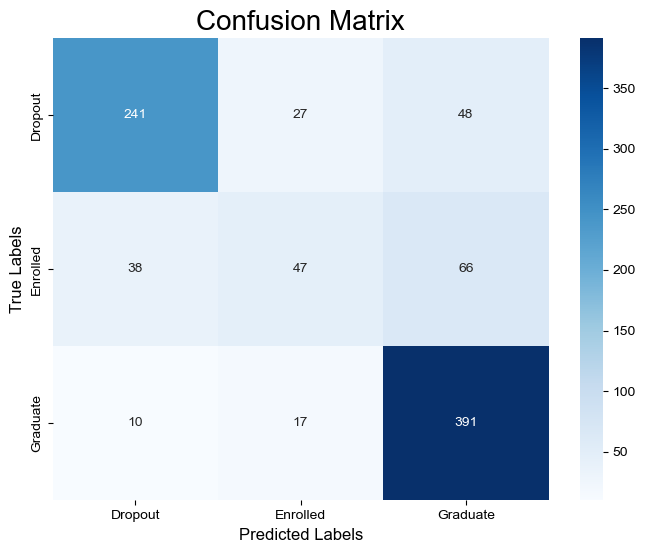

In [40]:
cm_data = np.array([[241, 27, 48], [38, 47, 66], [10, 17, 391]])
class_labels = ['Dropout', 'Enrolled', 'Graduate']
# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()